In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
import math 
import torchviz

In [2]:
PARAMS_CONFIG = {
    # env-specific
    'env_params': {
        '--distributed': {
            'action': 'store_true',
            'default': False,
            'help': 'enable distributed training.'
                    '(otherwise will use all available GPUs with dataparallel)',
            'dest': 'distributed'
        },
        '--local_rank': {
            'type': int,
            'default': 0,
            'help': 'used in distributed training',
            'dest': 'local_rank'
        },
    },
    # data-specific
    'data_params': {
        '--data': {
            'type': str,
            'default': 'data/text8',
            'help': 'data location '
                    '(must contain train.txt, valid.txt and test.txt)',
            'dest': 'data_path'
        },
        '--data-unit': {
            'type': str,
            'default': 'bpc',
            'choices': ['bpc', 'ppl'],
            'help': 'loss unit to log',
            'dest': 'data_unit'
        },
    },
    # model-specific
    'model_params': {
        '--hid-sz': {
            'type': int,
            'default': 256,
            'help': 'hidden size (i.e. model size)',
            'dest': 'hidden_size'
        },
        '--inner-hid-sz': {
            'type': int,
            'default': 1024,
            'help': 'inner hidden size of FF layer',
            'dest': 'inner_hidden_size'
        },
        '--nlayers': {
            'type': int,
            'default': 8,
            'help': 'number of layers',
            'dest': 'nb_layers'
        },
        '--block-sz': {
            'type': int,
            'default': 64,
            'help': 'block size '
                    '(the length of sequence to process in parallel)',
            'dest': 'block_size'
        },
        '--nheads': {
            'type': int,
            'default': 2,
            'help': 'number of self-attention heads',
            'dest': 'nb_heads'
        },
        '--attn-span': {
            'type': int,
            'default': 32,
            'help': 'length of the attention span',
            'dest': 'attn_span'
        },
        '--dropout': {
            'type': float,
            'default': 0.2,
            'help': 'dropout rate of ReLU and attention',
            'dest': 'dropout'
        },
        '--emb-dropout': {
            'type': float,
            'default': 0.,
            'help': 'the dropout rate applied on I/O embeddings',
            'dest': 'emb_dropout'
        },
    },
    # optimization-specific
    'optim_params': {
        '--lr': {
            'type': float,
            'default': 0.03,
            'help': 'learning rate',
            'dest': 'lr'
        },
        '--momentum': {
            'type': float,
            'default': 0.9,
            'help': 'SGD momentum',
            'dest': 'momentum'
        },
        '--optim': {
            'type': str,
            'default': 'sgd',
            'help': 'optimization method: sgd | adagrad',
            'dest': 'optim'
        },
        '--lr-warmup': {
            'type': int,
            'default': 0,
            'help': 'linearly increase LR from 0 '
                    'during first lr_warmup updates',
            'dest': 'lr_warmup'
        },
        '--grad-clip': {
            'type': float,
            'default': 0,
            'help': '[only works with adagrad!] '
                    'clip gradient of each module parameters by a given '
                    'value',
            'dest': 'grad_clip'
        },
    },
    # trainer-specific
    'trainer_params': {
        '--batch-sz': {
            'type': int,
            'default': 64,
            'help': 'batch size',
            'dest': 'batch_size'
        },
        '--batch-split': {
            'type': int,
            'default': 1,
            'help': 'split a batch into smaller parts to fit in GPU memory',
            'dest': 'batch_split'
        },
        '--nbatches': {
            'type': int,
            'default': 1000,
            'help': 'number of batches in each iteration',
            'dest': 'nb_batches_per_iter'
        },
        '--niter': {
            'type': int,
            'default': 1000,
            'help': 'number of iterations to train',
            'dest': 'nb_iter'
        },
        '--checkpoint': {
            'type': str,
            'default': '',
            'help': 'path to save/load model',
            'dest': 'checkpoint_path'
        },
        '--full-eval-mode': {
            'action': 'store_true',
            'default': False,
            'help': 'do evaluation on the whole validation and the test data',
            'dest': 'full_eval_mode'
        },
    },
    # adaptive I/O specific params
    'adapt_io_params': {
        '--adapt-io': {
            'action': 'store_true',
            'default': False,
            'help': 'enable adaptive input and output representations',
            'dest': 'adapt_io_enabled'
        },
        '--adapt-io-tied': {
            'action': 'store_true',
            'default': False,
            'help': 'tie the input parameters with the output parameters',
            'dest': 'adapt_io_tied'
        },
        '--adapt-io-divval': {
            'type': int,
            'default': 4,
            'help': 'dimension division value',
            'dest': 'adapt_io_divval'
        },
        '--adapt-io-cutoffs': {
            'type': int,
            'default': [20000, 40000, 200000],
            'help': 'cutoffs values',
            'dest': 'adapt_io_cutoffs'
        },
    },
    # adaptive attention span specific params
    'adapt_span_params': {
        '--adapt-span': {
            'action': 'store_true',
            'default': False,
            'help': 'enable adaptive attention span',
            'dest': 'adapt_span_enabled'
        },
        '--adapt-span-loss': {
            'type': float,
            'default': 0,
            'help': 'the loss coefficient for span lengths',
            'dest': 'adapt_span_loss'
        },
        '--adapt-span-ramp': {
            'type': int,
            'default': 32,
            'help': 'ramp length of the soft masking function',
            'dest': 'adapt_span_ramp'
        },
        '--adapt-span-init': {
            'type': float,
            'default': 0,
            'help': 'initial attention span ratio',
            'dest': 'adapt_span_init'
        },
        '--adapt-span-cache': {
            'action': 'store_true',
            'default': False,
            'help': 'adapt cache size as well to reduce memory usage',
            'dest': 'adapt_span_cache'
        },
    },
    # persistent memory specific params
    'pers_mem_params': {
        '--pers-mem-size': {
            'type': int,
            'default': 0,
            'help': 'the number of persistent memory vectors',
            'dest': 'pers_mem_size'
        },
    },
}

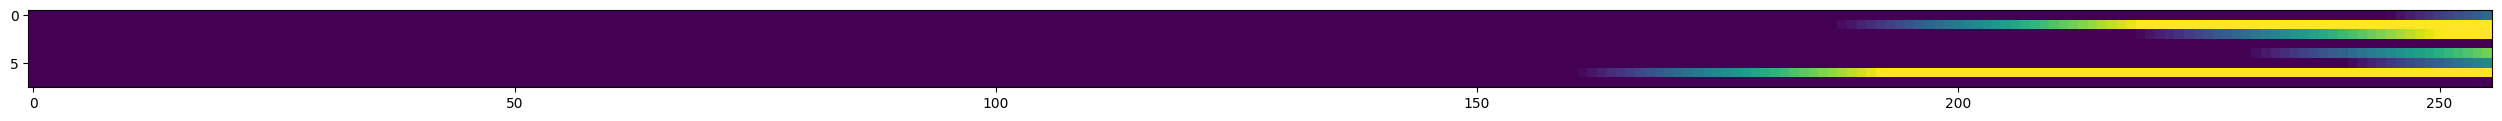

In [51]:
plt.figure(figsize=(100, 1))
plt.imshow(((torch.linspace(1-256, 0, 256) + torch.randn(8,1,1) * 30) / 32 + 1).clamp(0, 1).view(8, -1))

In [55]:
attn = torch.randn((128, 64, 32)).reshape(128//8, 8, 64, -1)


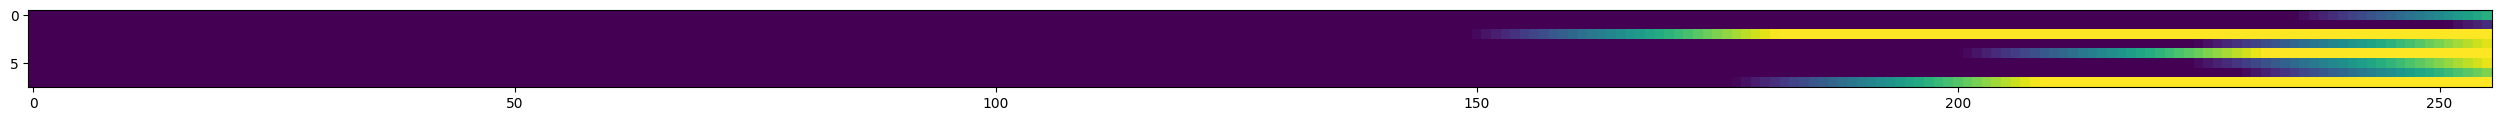

In [59]:
plt.figure(figsize=(100, 1))
mask = ((torch.linspace(1-256, 0, 256) + torch.randn(8,1,1) * 30) / 32 + 1).clamp(0, 1)
plt.imshow(mask.view(8, -1))

In [62]:
attn.shape, mask.shape, mask[:, :, -32:].shape

(torch.Size([16, 8, 64, 32]), torch.Size([8, 1, 256]), torch.Size([8, 1, 32]))

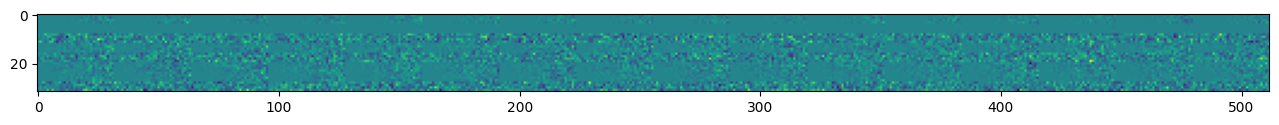

In [69]:
plt.figure(figsize=(100, 1))
plt.imshow((attn * mask[:, :, -32:])[0].view(8*4, -1))

In [3]:
class adaptive_mask(nn.Module): 
	def __init__(self, max_size, ramp_size, init_val=0, shape=(1,)): 
		super().__init__() 
		self._max_size = max_size 
		self._ramp_size = ramp_size 
		self.current_val = nn.Parameter(torch.zeros(*shape) + init_val) # is set to 0 by default and changes by back prop
		mask_template = torch.linspace(1 - max_size, 0, steps=max_size) 
		self.register_buffer('mask_template', mask_template) # register_buffer makes it so that 'mask_template' is not changed by the optimizer while training 
		
	def forward(self, x): # the only parameter that can be changed by the optimizer here is the 'current_val'.
		mask = self.mask_template + self.current_val * self._max_size # 'mask_template' is a tensor from (1 - 'max_size') to 0. 
		mask = mask / self._ramp_size + 1 # creates a graph from -ve whatever number (based on the ramp size) to 0. 
		mask = mask.clamp(0, 1) # this actually creates the ramp function by converting everything in the negative side to 0. 
		if x.size(-1) < self._max_size: 
			mask = mask[:, :, -x.size(-1):] # if the final dimension for mask is higher, make it the same as the input so you can multiply them
		x = x * mask # element-wise multiplication of 'x' and 'mask' 
		return x # return the masked input
	
	def clamp_param(self): 
		self.current_val.data.data.clamp_(0, 1)

class adaptive_span(nn.Module): 
	def __init__(self, attn_span, adapt_span_loss, adapt_span_ramp, 
	      adapt_span_init, adapt_span_cache, nb_heads, **kargs): 
		super().__init__()

		self._adapt_cache = adapt_span_cache 
		self._max_span = attn_span 
		self._loss_coeff = adapt_span_loss 
		self._nb_heads = nb_heads 
		self._mask = adaptive_mask(max_size=self._max_span, 
			     										ramp_size=adapt_span_ramp,
															init_val=adapt_span_init, 
															shape=(nb_heads, 1, 1))

	def forward(self, attn, normalize=True): # torch.Size([128, 64, 32])
		print(attn.shape)
		B = attn.size(0) # batch size
		M = attn.size(1) # length of sentence 
		attn = attn.reshape(B // self._nb_heads, self._nb_heads, M, -1) # reshaped it to (batch_size, attention_heads, sen_len, dim_per_head)
		attn = self._mask(attn) # gives back the masked attention
		if normalize: 
			attn = attn / (attn.sum(-1, keepdim=True) + 1e-8) # normalize it 

		attn = attn.view(B, M, -1) # returns the original shape 
		return attn 
	
	def get_cache_size(self): 
		if self._adapt_cache: 
			trim_len = self.get_trim_len()
			return min(self._max_span, self._max_span - trim_len + 64) # a buffer of 64 since span might increase in future updates 
		else: 
			return self._max_span
		
	def get_trim_len(self): 
		L = self._max_span 
		trim_len = min(L-1, L - self._mask.get_current_max_size()) 
		trim_len = math.floor(trim_len / 64) * 64 
		return trim_len 

	def get_loss(self): 
		return self._loss_coeff * self._max_span * self._mask.current_val.mean() 

In [4]:
class persistent_memory(nn.Module): 
	def __init__(self, size, nb_heads, head_dim, dropout): 
		super().__init__() 
		
		self.size = size 
		self.nb_heads = nb_heads 
		self.head_dim = head_dim 

		self.key = nn.Parameter(torch.randn(self.nb_heads, self.head_dim, self.size) / math.sqrt(self.head_dim))
		self.val = nn.Parameter(torch.randn(self.nb_heads, self.size, self.head_dim) / math.sqrt(self.size))
		self.dropout = nn.Dropout(dropout) 
		self.adaptive_span = None 

	def forward(self, query, attn): # you get query and attention
		key = self.key.unsqueeze(0) # key is a random variable of (num_heads, head_dim, size)
		val = self.val.unsqueeze(0) # value is a random variable of (num_heasd, size, head_dim) 
		# you need to divide both key and value by sqrt of the dimension (or size) to make it between -1 and 1

		query = query.view((-1, self.nb_heads) + query.size()[1:]) # 
		attn_pers = torch.matmul(query, key * math.sqrt(self.head_dim))
		attn_pers = attn_pers.view((-1,) + attn_pers.size()[2:])

		attn = torch.cat((attn, attn_pers), dim=-1)
		attn = attn / math.sqrt(self.head_dim) 
		attn = torch.softmax(attn, dim=-1)
		attn_pers = attn[:, :, -key.size(-1):]
		attn = attn[:, :, :-key.size(-1)]

		if self.adaptive_span is not None: 
			attn = self.adaptive_span(attn, normalize=False)
			attn = torch.cat((attn, attn_pers), dim=-1)
			attn = attn / (attn.sum(-1, keepdim=True) + 1e-8)
			attn_pers = attn[:, :, -key.size(-1):]
			attn = attn[:, :, :-key.size(-1)]

		attn_pers = self.dropout(attn_pers)
		
		attn_pers = attn_pers.view((-1, self.nb_heads) + attn_pers.size()[1:])
		out = torch.matmul(attn_pers, val * math.sqrt(self.size))
		out = out.view((-1,) + out.size()[2:])
		return attn, out 

In [5]:
class adaptive_embedding(nn.Module): 
	def __init__(self, n_tokens, d_embed, d_proj, cutoffs, div_val=4): 
		super().__init__() 
		self.n_tokens = n_tokens  
		self.d_embed = d_embed 
		self.d_proj = d_proj 
		
		assert 0 < min(cutoffs) <= max(cutoffs) < n_tokens 
		self.cutoffs = cutoffs + [n_tokens] 
		self.cutoff_ends = [0] + self.cutoffs 
		self.div_val = div_val 
		assert self.div_val > 1 
		assert len(self.cutoffs) > 1 

		self.emb_scale = d_proj ** 0.5 

		self.emb_layers = nn.ModuleList() 
		self.emb_projs = nn.ParameterList() 

		for i in range(len(self.cutoffs)): 
			l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1]
			d_emb_i = d_embed // (div_val ** i) 
			self.emb_layers.append(nn.Embedding(r_idx - l_idx, d_emb_i)) 
			self.emb_projs.append(nn.Linear(d_emb_i, d_proj).weight)

	def forward(self, indices): # sentence indices are input
		param = self.emb_layers[0].weight.data # weights of the first embedding layer of 'emb_layers' 
		idx_flat = indices.contiguous().view(-1) # makes the whole batch of sentences into a 1-d matrix. 
		emb_flat = torch.zeros([idx_flat.size(0), self.d_proj], dtype=param.dtype, device=param.device) # a tensor with the number of words, and projected output as dimensions. 

		for i in range(len(self.cutoffs)): # indices between each cutoff has a different Embedding layer. 
			l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1] # gets the start and end indices of each cutoff 
			mask_i = (idx_flat >= l_idx) & (idx_flat < r_idx) # checks whether each index is between cutoffs. 

			indices_i = mask_i.nonzero().squeeze() # gets just the words of the selected indices 
			if indices_i.numel() == 0: # if there are no words, then continue
				continue 

			idx_i = idx_flat.index_select(0, indices_i) - l_idx # filters down to only the required indices. 
			# then it minuses the 'l_idx' to get the indices between 0 and (r_idx - l_idx) since each Embedding layer is a different layer
			emb_i = self.emb_layers[i](idx_i) # gets embeddings for the selected words 
			emb_i = F.linear(emb_i, self.emb_projs[i]) # linear function between the current embeddings and the projected embeddings. 
			emb_flat = emb_flat.type_as(emb_i) if emb_flat.dtype != emb_i.dtype else emb_flat # changes the datatype of 'emb_flat' if it is different to 'emb_i'
			emb_flat.index_copy_(0, indices_i, emb_i) # copies the output from each 'emb_projs' back into the original tensor. 

		embed = emb_flat.view(*indices.size(), self.d_proj) # reshapes the outputs into the original shape, and projected output
		embed.mul_(self.emb_scale) # multiplies the embedded input with the scale. scale is the square root of the projected dimension. 
		# it increases the vectors since the emb_scale is > 1. Why? 
		return embed 
	
class projected_adaptive_log_softmax(nn.Module): 
	def __init__(self, n_tokens, d_embed, d_proj, cutoffs, div_val=4): 
		super().__init__() 

		self.n_tokens = n_tokens 
		self.d_embed = d_embed 
		self.d_proj = d_proj 

		assert 0 < min(cutoffs) <= max(cutoffs) < n_tokens 
		self.cutoffs = cutoffs + [n_tokens]
		self.cutoff_ends = [0] + self.cutoffs 
		self.div_val = div_val 
		assert self.div_val > 1 
		assert len(self.cutoffs) > 1 

		self.shortlist_size = self.cutoffs[0] 
		self.n_clusters = len(self.cutoffs) - 1 
		self.head_size = self.shortlist_size + self.n_clusters 

		self.cluster_proj = nn.Linear(self.d_embed, self.n_clusters) 

		self.out_layers = nn.ModuleList() 
		self.out_projs = nn.ParameterList() 

		for i in range(len(self.cutoffs)): 
			l_idx, r_idx = self.cutoff_ends[i], self.cutoff_ends[i + 1] 
			d_emb_i = d_embed // (div_val ** i) 
			self.out_projs.append(nn.Linear(d_emb_i, d_proj).weight)
			self.out_layers.append(nn.Linear(d_emb_i, r_idx - l_idx)) 
			
	def compute_logit(self, hidden, weight, bias, proj):
		proj_hid = F.linear(hidden, proj.t().contiguous()) # multiplies the hidden output to the projection weights 
		logit = F.linear(proj_hid, weight, bias=bias) # gets the final logits by --> w.x + b 
		return logit 
	
	def forward(self, hidden, target): # input are the hidden vectors, and the target vectors. 
		assert hidden.shape[-1] == self.d_proj 
		assert hidden.shape[:-1] == target.shape 
		shape = target.shape 
		hidden = hidden.view(-1, self.d_proj) # reshapes the tensor to only contain all the words and the final projection layer. 
		target = target.view(-1) 

		weights, biases = list(), list() 
		for i in range(len(self.cutoffs)): 
			weight_i = self.out_layers[i].weight # get the weights from each linear layer corresponding to the 'out_layer'
			bias_i = self.out_layers[i].bias # get the biases too
			if i == 0: # if this is the first item in the list
				weight_i = torch.cat([weight_i, self.cluster_proj.weight], dim=0) # concatenate the weight with the cluster projection
				bias_i = torch.cat([bias_i, self.cluster_proj.bias], dim=0) # concatenate the bias
			weights.append(weight_i) # weights and biases are saved in lists. 
			biases.append(bias_i) 
		
		head_logit = self._compute_logit(hidden, weights[0], biases[0], self.out_projs[0]) # each layer in out_layer has a different dimension so it is done this way. 
		head_logprob = F.log_softmax(head_logit.float(), dim=1) # log_softmaxing the output to get the probabilities 

		nll = torch.zeros_like(target, dtype=torch.float32, device=hidden.device) # to calculate the negative log-likelihood loss 

		offset = 0 
		cutoff_values = [0] + self.cutoffs 

		for i in range(len(cutoff_values) - 1): 
			l_idx, r_idx = cutoff_values[i], cutoff_values[i + 1] # get the cutoff values
			mask_i = (target >= l_idx) & (target < r_idx) # get the masks for the selected cutoff values
			indices_i = mask_i.nonzero().squeeze() # find out if teh mask contains any values or not

			if indices_i.numel() == 0: # check if there are any values
				continue 

			target_i = target.index_select(0, indices_i) - l_idx # select the targets with the corresponding indices from the target 
			head_logprob_i = head_logprob.index_select(0, indices_i) # selects the items from the predicted output

			if i == 0: 
				logprob_i = head_logprob_i.gather(1, target_i[:, None].long()).squeeze(1) # if it is the first time, gathers all the items from the 'target_i'
				# first time only has the head while all subsequent times has a head and a tail. 
			else: 
				hidden_i = hidden.index_select(0, indices_i) # selects the required outputs from the hidden layers. 
				tail_logit_i = self._compute_logit(hidden_i, weights[i], biases[i], self.out_projs[i]) # computes the logits 
				tail_logprob_i = F.log_softmax(tail_logit_i.float(), dim=1) # log probabilities are calculated 
				logprob_i = head_logprob_i[:, -i] + tail_logprob_i.gather(1, target_i[:, None]).squeeze(1) # head and tail log probabilities are added 

			nll.index_copy_(0, indices_i, -logprob_i) # inputs all the indices back into 'nll' 

			offset += logprob_i.size(0) # no idea why this is here. It is never used and it just increases within this loop

		return nll.view(shape) # reshape 'nll' back into the original shape
	
	def _compute_logit(self, hidden, weight, bias, proj): 
		proj_hid = F.linear(hidden, proj.t().contiguous()) 
		logit = F.linear(proj_hid, weight, bias=bias) 
		return logit

def compute_dummy_loss(in_emb, out_emb): 
	dummy_loss = 0 * (
		sum(x.weight[0, 0] for x in in_emb.emb_layers) + 
		sum(x[0, 0] for x in in_emb.emb_projs) + 
		sum(x[0, 0] for x in out_emb.out_projs) + 
		sum(x.weight[0, 0] for x in out_emb.out_layers) + 
		sum(x.bias[0] for x in out_emb.out_layers)
	)
	return dummy_loss 

def build_adaptive_io(vocab_size, hidden_size, adapt_io_cutoffs, adapt_io_divval,
		      adapt_io_tied, **kargs): 
	in_emb = adaptive_embedding(vocab_size, hidden_size, hidden_size, 
			     cutoffs=adapt_io_cutoffs, div_val=adapt_io_divval)
	out_emb = projected_adaptive_log_softmax(vocab_size, hidden_size, hidden_size,
					  cutoffs=adapt_io_cutoffs, div_val=adapt_io_divval)

	if adapt_io_tied: # it is False by default 
		for i in range(len(adapt_io_cutoffs) + 1): 
			out_emb.out_layres[i].weight = in_emb.emb_layers[i].weight 
			out_emb.out_projs[i] = in_emb.emb_projs[i] 
	return in_emb, out_emb 

In [7]:
def _skew(X, pad_value): 
	B, M, L = X.size() 
	X = F.pad(X, (0, M+1), value=pad_value)
	X = X.view(B, -1) 
	X = X[:, :-M]
	X = X.view(B, M, M+L)
	return X 

def _unskew(X): 
	B, M, L = X.size() 
	L -= M 
	X = X.view(B, -1) 
	X = F.pad(X, (0, M))
	X = X.view(B, M, M+L+1)
	X = X[:, :, :L]
	return X

class seq_attention(nn.Module): 
	def __init__(self, hidden_size, nb_heads, attn_span, dropout, 
	      			adapt_span_params, pers_mem_params, **kargs): 
		super().__init__() 
		self.dropout = nn.Dropout(dropout) 
		self.hidden_size = hidden_size 
		self.attn_span = attn_span 
		self.adapt_span_enabled = adapt_span_params['adapt_span_enabled']
		if self.adapt_span_enabled: 
			self.adaptive_span = adaptive_span(attn_span=attn_span, nb_heads=nb_heads,
				      													**adapt_span_params, **kargs)
		self.persistent_memory = None 
		if pers_mem_params['pers_mem_size'] > 0: 
			self.persistent_memory = persistent_memory(pers_mem_params['pers_mem_size'],
					      																nb_heads=nb_heads, head_dim=hidden_size, 
																								dropout=dropout)
			if self.adapt_span_enabled: 
				self.persistent_memory.adaptive_span = self.adaptive_span 

	def forward(self, query, key, value, key_pe): 
		print(f'query: {query.shape}, key: {key.shape}, value: {value.shape}, key_pe: {key_pe.shape}')
		attn_cont = torch.matmul(query, key.transpose(-1, -2)) # 'query' @ 'key' 
		print(f'attn_cont: {attn_cont.shape}')
		attn_cont = _unskew(attn_cont) 
		print(f'attn_cont unskew: {attn_cont.shape}')

		attn_pos = torch.matmul(query, key_pe) # 'key_pe' are the learnable parameters for position (?) # 'attn_pos' is positional attention
		print(f'attn_pos: {attn_pos.shape}')
		attn = attn_cont + attn_pos # get the full attention by adding it
		print(f'attn after addition: {attn.shape}')
		# the above is the code of the equation: s_{tr} = x_t^T W_q^T(W_k x_r + p_{t-r})

		if self.persistent_memory is not None: # you do not have persistent memory by default, i.e., 'pers_mem_size' = 0 
			attn, pers_mem_out = self.persistent_memory(query, attn) 
		else: 
			attn = attn / math.sqrt(self.hidden_size) # you need to divide by sqrt of size to not create peaks in a graph when you softmax it
			attn = torch.softmax(attn, dim=-1) # softmaxing the data makes everything positive and easier to understand 

			if self.adapt_span_enabled: # adaptive span is the main part of this paper. It should be enabled although it is not enabled by default.  
				attn = self.adaptive_span(attn) # returns the attention vector with adaptive span. 

		attn = self.dropout(attn) # use the dropout in attention. 

		attn_cont = _skew(attn, 0) # skewing the attention moves every subsequent data by 1 position to the right. 
		out = torch.matmul(attn_cont, value) # 'attn_cont' @ 'value' gives the final attention output

		if self.persistent_memory is not None: # persistent memory is not enabled by default. 
			out = out + pers_mem_out 

		return out # back to 'multi_head_seq_attention' 
	
	def get_cache_size(self): 
		if self.adapt_span_enabled: 
			return self.adaptive_span.get_cache_size() 
		else: 
			return self.attn_span

class multi_head_seq_attention(nn.Module): 
	def __init__(self, hidden_size, nb_heads, **kargs): 
		super().__init__() 
		assert hidden_size % nb_heads == 0 
		self.nb_heads = nb_heads 
		self.head_dim = hidden_size // nb_heads 
		self.attn = seq_attention(hidden_size=self.head_dim, nb_heads=nb_heads, **kargs)
		self.proj_query = nn.Linear(hidden_size, hidden_size, bias=False) 
		self.proj_out = nn.Linear(hidden_size, hidden_size, bias=False) 
		self.proj_val = nn.Linear(hidden_size, hidden_size, bias=False) 
		self.proj_key = nn.Linear(hidden_size, hidden_size, bias=False) 

	def head_reshape(self, x): # [16, 64, 512] --> [16, 64, 8, 64] --> [16, 8, 64, 64] --> [128, 64, 64]
		K = self.nb_heads 
		D = self.head_dim 
		x = x.view(x.size()[:-1] + (K, D))
		x = x.transpose(1, 2).contiguous() 
		x = x.view(-1, x.size(-2), x.size(-1))
		return x 
	
	def forward(self, query, key, value, key_pe): # 'query' is the sentence embedding, 
		# 'key' and 'value' are sentence embeddings and previous sentence embeddings concatenated 
		# 'key_pe' is a learnable parameter. 
		B = query.size(0) # batch 
		K = self.nb_heads # key
		D = self.head_dim # head dimension
		M = query.size(1) # sentence length

		query = self.proj_query(query) # projecting (?) the query by matrix multiplying with a weight. 
		query = self.head_reshape(query) # they are reshaped to make it easier to apply attention. It divides the attention head and its dimensions, and then it joins the batch size and
		value = self.proj_val(value) # number of heads. Finally, instead of the batch size, you will have each head in the first dimension of the tensor. 
		value = self.head_reshape(value) 
		key = self.proj_key(key) 
		key = self.head_reshape(key) 

		out = self.attn(query, key, value, key_pe) # you get the attention output. It gives you a matrix of how each word relates to another word
		out = out.view(B, K, M, D) # reshaping the attention output into (batch, key_dim, sentence_len, dimension)
		out = out.transpose(1, 2).contiguous() # reshaping the attention output into (batch, sentence_len, key_dim, dimension) 
		out = out.view(B, M, -1) # reshaping it so that the key, and dimensions are mixed together. 
		out = self.proj_out(out) # 'K * D = hidden_dim' since, 'self.head_dim = hidden_size // nb_heads' and 'hidden_size % nb_heads == 0' 
		return out # output of the multi-headed sequential attention 
	
class feed_forward_layer(nn.Module): 
	def __init__(self, hidden_size, inner_hidden_size, dropout, **kargs): 
		super().__init__() 
		self.fc1 = nn.Linear(hidden_size, inner_hidden_size) 
		self.fc2 = nn.Linear(inner_hidden_size, hidden_size) 
		self.dropout = nn.Dropout(dropout) 

	def forward(self, h): 
		h1 = F.relu(self.fc1(h)) 
		h1 = self.dropout(h1) 
		h2 = self.fc2(h1) 
		return h2 
	
class transformer_seq_layer(nn.Module): 
	def __init__(self, hidden_size, **kargs): 
		super().__init__() 
		self.attn = multi_head_seq_attention(hidden_size=hidden_size, **kargs) 
		self.norm1 = nn.LayerNorm(hidden_size) 
		if kargs['pers_mem_params']['pers_mem_size'] > 0: 
			self.ff = None 
		else: 
			self.ff = feed_forward_layer(hidden_size=hidden_size, **kargs) 
			self.norm2 = nn.LayerNorm(hidden_size) 

	def forward(self, h, h_cache, key_pe): # the input is an embedded sentence 'h', a personalized cache for this specific layer of transformer 'h_cache',
		# and a parameter 'key_pe' of size (1, 64, 32) 
		h_all = torch.cat([h_cache, h], dim=1) # the 'h_cache' and 'h' are concatenated which increases the number of sentences
		attn_out = self.attn(h, h_all, h_all, key_pe) # 'attn' is the multi headed sequential attention 
		h = self.norm1(h + attn_out) # residual connection after the attention (addition and normalization). Basic transformer structure. 
		if self.ff is not None: # it is not None by default because by default 'pers_mem_size' = 32 
			ff_out = self.ff(h) # 'ff' is a feed forward network with relu, and 2 linear layers with a dropout layer in the middle. 
			out = self.norm2(h + ff_out) # residual connection after the feed-forward layer (addition and normalization). Basic transformer structure. 
		else: 
			out = h 
		return out # output of the transformer layer. 
	
class transformer_seq(nn.Module): 
	def __init__(self, vocab_size, hidden_size, nb_heads, nb_layers, 
	      			attn_span, emb_dropout, adapt_io_params, **kargs): 
		super().__init__()
		self.adapt_io = adapt_io_params['adapt_io_enabled']
		if self.adapt_io: 
			self.in_emb, self.out_emb = build_adaptive_io(vocab_size, hidden_size, **adapt_io_params)
		else: 
			self.in_emb = nn.Embedding(vocab_size, hidden_size) 
			self.out_emb = nn.Linear(hidden_size, vocab_size)  
		if emb_dropout > 0: 
			self.emb_dropout = nn.Dropout(emb_dropout) 
		else: 
			self.emb_dropout = None 
		
		self.key_pe = nn.Parameter(torch.randn(1, hidden_size // nb_heads, attn_span))

		self.layers = nn.ModuleList() 
		self.layers.extend(transformer_seq_layer(hidden_size=hidden_size,
					   																nb_heads=nb_heads, attn_span=attn_span, 
																						**kargs)
											for _ in range(nb_layers))

	def forward(self, x, h_cache, target=None): 
		# 'x' is the batched input sentence, 'h_cache' is a list of zero tensors of (B, cache_size, emb_dim) for each 'tarnsformer_seq_layer' there is BY DEFAULT
		# 'h_cache' actually stores the previous 'transformer_seq_layer' outputs. 
		block_size = x.size(1) # checks the number of words in a data point 
		h = self.in_emb(x) # embeds the input into 'h' hidden
		if self.emb_dropout is not None: # drops-out the 'h' if it is enabled 
			h = self.emb_dropout(h) 

		h_cache_next = list() # maintains a cache list for 'h' 
		for l, layer in enumerate(self.layers): # self.layers is a list of transformer sequential layers depending on the parameter 'nb_layers' 
			cache_size = layer.attn.attn.get_cache_size() # returns the 'attn_span' by default which is 32 by default. 
			if cache_size > block_size: # if your cache is greater than the sentence you input
				h_cache_next_l = torch.cat(
					[h_cache[l][:, -cache_size + block_size:, :], h], dim=1).detach()
			else: # if your cache is not greater than the sentence you input
				h_cache_next_l = h[:, -cache_size:, :].detach() # you take just the embeddings of the last cache_sized chunk 
			h_cache_next.append(h_cache_next_l) # then it gets added into the cache list 
			h = layer(h, h_cache[l], self.key_pe) # the embedded sentence 'h', 'h_cache' based on which layer, and 'key_pe' is input into the layer. 
			# 'key_pe' is a parameter which is (1, 64, 32) by default in size. 
		# inputs the old transformer's output into the next transformer until it goes through all the layers. 
		
		if self.emb_dropout is not None: # 'emb_dropout' is 0.2 by default. 
			h = self.emb_dropout(h) # drops-out 'h' 
		if self.adapt_io: # depends on 'adapt_io_enabled' which is True by default. 
			out = self.out_emb(h, target) # the output embedding layer takes the 'h', and 'target' to give the 'nll' output
			dummy_loss = compute_dummy_loss(self.in_emb, self.out_emb) # its a fake loss function where you can add your own loss function. 
		else: 
			out = F.log_softmax(self.out_emb(h), dim=-1) 
			dummy_loss = None 

		return out, h_cache_next, dummy_loss # out is the 'nll' output, 'h_cache_next' is all the 'h' outputs that are cached, 'dummy_loss' can be your loss. 

model = transformer_seq(vocab_size=300000, hidden_size=512, nb_heads=8, nb_layers=8,
                attn_span=32, emb_dropout=0.2, adapt_io_params={'adapt_io_enabled': True, 'adapt_io_tied': False, 'adapt_io_divval': 4, 'adapt_io_cutoffs': [20000, 40000, 200000]}, 
                dropout=0.2, adapt_span_params={'adapt_span_enabled': True, 'adapt_span_loss': 0,
                                                'adapt_span_ramp': 32, 'adapt_span_init': 0, 'adapt_span_cache': False},
                                                pers_mem_params={'pers_mem_size': 0}, inner_hidden_size=256)

x = torch.randint(0, 300000, size=(16, 64))
h_cache = [torch.zeros((x.size(0), layer.attn.attn.get_cache_size(), 512)) for layer in model.layers]
loss, data_pos, hid_cache = model(x, h_cache=h_cache, target=torch.zeros((16, 64), dtype=torch.float32))

query: torch.Size([128, 64, 64]), key: torch.Size([128, 96, 64]), value: torch.Size([128, 96, 64]), key_pe: torch.Size([1, 64, 32])
attn_cont: torch.Size([128, 64, 96])
attn_cont unskew: torch.Size([128, 64, 32])
attn_pos: torch.Size([128, 64, 32])
attn after addition: torch.Size([128, 64, 32])
torch.Size([128, 64, 32])
query: torch.Size([128, 64, 64]), key: torch.Size([128, 96, 64]), value: torch.Size([128, 96, 64]), key_pe: torch.Size([1, 64, 32])
attn_cont: torch.Size([128, 64, 96])
attn_cont unskew: torch.Size([128, 64, 32])
attn_pos: torch.Size([128, 64, 32])
attn after addition: torch.Size([128, 64, 32])
torch.Size([128, 64, 32])
query: torch.Size([128, 64, 64]), key: torch.Size([128, 96, 64]), value: torch.Size([128, 96, 64]), key_pe: torch.Size([1, 64, 32])
attn_cont: torch.Size([128, 64, 96])
attn_cont unskew: torch.Size([128, 64, 32])
attn_pos: torch.Size([128, 64, 32])
attn after addition: torch.Size([128, 64, 32])
torch.Size([128, 64, 32])
query: torch.Size([128, 64, 64]), 

In [134]:
model.layers[0].attn.attn.get_cache_size()

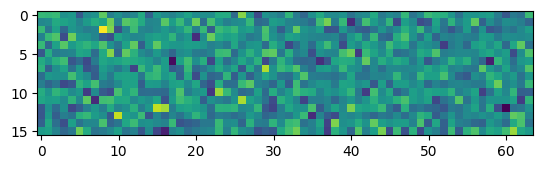

In [136]:
plt.imshow(loss.detach())

In [127]:
x

tensor([[ 84827,  80145,  76117,  ..., 242922,  61511, 165573],
        [ 62052,  52365,  68322,  ..., 117377,  51693, 268640],
        [286807, 190639, 264152,  ..., 202235, 199054, 144162],
        ...,
        [198826, 289914,  96415,  ..., 270614, 278976,  90573],
        [ 29556, 184064, 147949,  ...,   3481, 235219,  31077],
        [ 77276, 267976, 247518,  ...,  91507, 294180, 172438]])